# Example Training Script


Set up an ensemble of fine-tuned mace potentials 

In [14]:
%matplotlib inline
from pathlib import Path
from matplotlib import pyplot as plt
from mace.calculators.foundations_models import mace_mp
from mace.data.utils import config_from_atoms, compute_average_E0s
from mace.data import AtomicData
from mace.modules import WeightedEnergyForcesLoss, scaling_classes
from mace.tools.torch_geometric.dataloader import DataLoader
from ignite.engine import Engine, Events
from ignite.metrics import Loss
from ase.io import iread
from tqdm import tqdm
from torch import nn
import pandas as pd
import numpy as np
import torch

## Load MD Dataset
Load the MD data from our previous runs. Currently we have four demo trajectories and will use the first three for training

In [16]:
data_dir = '../0_setup/md/'
train_files = [f'packmol-CH4-in-H2O=32-seed={i}-blyp-npt=298/md.traj' for i in range(3)]

In [31]:
for file in train_files: 
    file = Path(data_dir) / file
    assert file.exists(), "File must exist" 

In [33]:
configs = []
for file in train_files: 
    file = Path(data_dir) / file
    assert file.exists(), "File must exist" 
    for atoms in iread(file):
        # Move the data into an "info" so MACE can find it
        atoms.info = {
            'energy': atoms.get_potential_energy(),
            'stress': atoms.get_stress()
        }
        atoms.arrays.update({
            'forces': atoms.get_forces(),
            'positions': atoms.positions,
        })
        configs.append(config_from_atoms(atoms))

## Load the Starting Model
We are going to start from the [MACE-MP Medium](https://arxiv.org/abs/2401.00096) model.

The first step is to re-compute the "atomic energies" to account for differences in energy scales for atomic refernece energies
The dataloader for MACE needs a "Z table" to match between atomic number and index in the nueral network. 
We are going to use the same one as the MACE-MP model

In [34]:
import torch
torch.cuda.is_available()

True

In [38]:
n_committee = 4

In [39]:
calc = mace_mp('small', device='cuda')

Using Materials Project MACE for MACECalculator with /home/mike/.cache/mace/46jrkm3v
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


In [40]:
calc.models[0]

ScaleShiftMACE(
  (node_embedding): LinearNodeEmbeddingBlock(
    (linear): Linear(89x0e -> 128x0e | 11392 weights)
  )
  (radial_embedding): RadialEmbeddingBlock(
    (bessel_fn): BesselBasis(r_max=6.0, num_basis=10, trainable=False)
    (cutoff_fn): PolynomialCutoff(p=5.0, r_max=6.0)
  )
  (spherical_harmonics): SphericalHarmonics()
  (atomic_energies_fn): AtomicEnergiesBlock(energies=[-3.6672, -1.3321, -3.4821, -4.7367, -7.7249, -8.4056, -7.3601, -7.2846, -4.8965, 0.0000, -2.7594, -2.8140, -4.8469, -7.6948, -6.9633, -4.6726, -2.8117, -0.0626, -2.6176, -5.3905, -7.8858, -10.2684, -8.6651, -9.2331, -8.3050, -7.0490, -5.5774, -5.1727, -3.2521, -1.2902, -3.5271, -4.7085, -3.9765, -3.8862, -2.5185, 6.7669, -2.5635, -4.9380, -10.1498, -11.8469, -12.1389, -8.7917, -8.7869, -7.7809, -6.8500, -4.8910, -2.0634, -0.6396, -2.7887, -3.8186, -3.5871, -2.8804, -1.6356, 9.8467, -2.7653, -4.9910, -8.9337, -8.7356, -8.0190, -8.2515, -7.5917, -8.1697, -13.5927, -18.5175, -7.6474, -8.1230, -7.6078, -6.

In [41]:
atomic_energies_dict = compute_average_E0s(configs, calc.z_table)
atomic_energies = np.array([atomic_energies_dict[z] for z in calc.z_table.zs])

In [42]:
assert len(calc.models) == 1
model = calc.models[0]

In [43]:
next(model.products.parameters()).size()

torch.Size([89, 23, 128])

In [44]:
with torch.no_grad():
    ae = model.atomic_energies_fn.atomic_energies
    model.atomic_energies_fn.atomic_energies = torch.from_numpy(atomic_energies).to(ae.dtype).to(ae.device)

Then readjust the "shift" of the energy scale

In [45]:
comparison = []
for atoms in tqdm(iread(train_file)):
    comparison.append({
        'dft': atoms.get_potential_energy() / len(atoms),
        'ml': calc.get_potential_energy(atoms) / len(atoms)
    })

512it [00:26, 19.56it/s]


In [46]:
comparison = pd.DataFrame(comparison)

In [47]:
comparison['error'] = (comparison['ml'] - comparison['dft'])
comparison['error'].describe()

count    512.000000
mean       0.010447
std        0.000971
min        0.007972
25%        0.009682
50%        0.010580
75%        0.011180
max        0.012326
Name: error, dtype: float64

In [14]:
model.scale_shift.shift -=  comparison['error'].mean()

Repeat analysis to make sure it gives the correct energy scale

In [15]:
comparison = []
for atoms in tqdm(iread(train_file)):
    comparison.append({
        'dft': atoms.get_potential_energy() / len(atoms),
        'dft-forces': atoms.get_forces(),
        'ml': calc.get_potential_energy(atoms) / len(atoms),
        'ml-forces': calc.get_forces(atoms),
    })

512it [00:25, 20.43it/s]


In [16]:
comparison = pd.DataFrame(comparison)

In [17]:
comparison['force_rmse'] = np.sqrt([np.power(x - y, 2).mean() for x, y in 
                                    zip(comparison['dft-forces'], comparison['ml-forces'])])

Text(0, 0.5, 'E, DFT (eV/atom)')

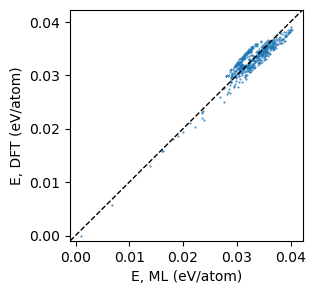

In [18]:
fig, ax = plt.subplots(figsize=(3., 3.))

ref = comparison.loc[comparison['dft'].argmin()]
ax.scatter(comparison['ml'] - ref['dft'], comparison['dft'] - ref['dft'], s=0.2)

ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_xlim())

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--', lw=1)

ax.set_xlabel('E, ML (eV/atom)')
ax.set_ylabel('E, DFT (eV/atom)')

## Run a Few Training Sets
Enough to show that we can get better

In [19]:
loader = DataLoader(
    [AtomicData.from_config(c, z_table=calc.z_table, cutoff=calc.r_max) for c in configs],
    batch_size=4,
    shuffle=True,
    drop_last=True,
)

Set some weights as eligible for training

In [20]:
for p in model.readouts.parameters():
    p.requires_grad = True

Define the loss function and optimizer

In [21]:
opt = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = WeightedEnergyForcesLoss(energy_weight=1.0, forces_weight=100.)

Define the trainer and evaluators

In [22]:
def train_step(engine, batch):
    """Borrowed from the training step used inside MACE"""
    model.train()
    opt.zero_grad()
    batch = batch.to('cuda')
    y = model(
        batch,
        training=True,
        compute_force=True,
        compute_virials=False,
        compute_stress=False,
    )
    loss = criterion(pred=y, ref=batch)
    loss.backward()
    opt.step()
    return loss.item()

In [23]:
val_metrics = {
    "loss": Loss(criterion)
}
trainer = Engine(train_step)

In [24]:
log_interval = 25
@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_epoch_time():
    print(f"Epoch {trainer.state.epoch}, Time Taken : {trainer.state.times['EPOCH_COMPLETED']}")
@trainer.on(Events.COMPLETED)
def log_total_time():
    print(f"Total Time: {trainer.state.times['COMPLETED']}")

In [25]:
trainer.state.times

{'EPOCH_COMPLETED': None, 'COMPLETED': None}

In [26]:
trainer.run(loader, max_epochs=64)

Epoch[1], Iter[25] Loss: 2.13
Epoch[1], Iter[50] Loss: 1.28
Epoch[1], Iter[75] Loss: 7.58
Epoch[1], Iter[100] Loss: 1.81
Epoch[1], Iter[125] Loss: 3.81
Epoch 1, Time Taken : 63.202730655670166
Epoch[2], Iter[150] Loss: 1.49
Epoch[2], Iter[175] Loss: 1.68
Epoch[2], Iter[200] Loss: 1.88
Epoch[2], Iter[225] Loss: 1.45
Epoch[2], Iter[250] Loss: 3.82
Epoch 2, Time Taken : 61.49806880950928
Epoch[3], Iter[275] Loss: 1.51
Epoch[3], Iter[300] Loss: 1.50
Epoch[3], Iter[325] Loss: 1.88
Epoch[3], Iter[350] Loss: 1.24
Epoch[3], Iter[375] Loss: 1.53
Epoch 3, Time Taken : 61.60580658912659
Epoch[4], Iter[400] Loss: 1.32
Epoch[4], Iter[425] Loss: 1.29
Epoch[4], Iter[450] Loss: 1.61
Epoch[4], Iter[475] Loss: 1.54
Epoch[4], Iter[500] Loss: 1.54
Epoch 4, Time Taken : 61.91881966590881
Epoch[5], Iter[525] Loss: 1.40
Epoch[5], Iter[550] Loss: 1.51
Epoch[5], Iter[575] Loss: 1.47
Epoch[5], Iter[600] Loss: 1.28
Epoch[5], Iter[625] Loss: 1.81
Epoch 5, Time Taken : 62.11845350265503
Epoch[6], Iter[650] Loss: 1

State:
	iteration: 8192
	epoch: 64
	epoch_length: 128
	max_epochs: 64
	output: 1.6027605533599854
	batch: <class 'mace.tools.torch_geometric.batch.Batch'>
	metrics: <class 'dict'>
	dataloader: <class 'mace.tools.torch_geometric.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [27]:
comparison['ml-next'] = [
    calc.get_potential_energy(atoms) / len(atoms) for atoms 
    in tqdm(iread(train_file))
]

512it [00:26, 19.43it/s]


In [28]:
comparison['ml-forces-next'] = [
    calc.get_forces(atoms) for atoms 
    in tqdm(iread(train_file))
]


512it [00:26, 19.55it/s]


In [29]:
comparison['force_rmse-next'] = np.sqrt([np.power(x - y, 2).mean() for x, y in 
                                    zip(comparison['dft-forces'], comparison['ml-forces-next'])])

In [30]:
comparison[['force_rmse', 'force_rmse-next']].describe()

,force_rmse,force_rmse-next
count,512.000000,512.000000
mean,0.129648,0.118579
std,0.041134,0.042720
min,0.069677,0.049437
25%,0.114177,0.101631
50%,0.124432,0.113708
75%,0.136421,0.126088
max,0.589726,0.585937


ml 0.001120540252890212
ml-next 0.01829095620862725


Text(0, 0.5, 'E, DFT (eV)')

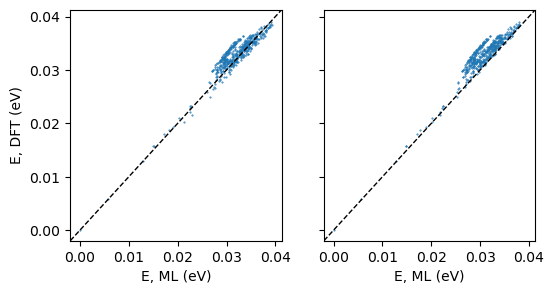

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(6., 3.), sharey=True, sharex=True)

ref = comparison.loc[comparison['dft'].argmin()]
for ax, c in zip(axs, ['ml', 'ml-next']):
    mae = (comparison['dft'] - comparison[c]).abs().mean()
    print(c, mae)
    
    ax.scatter(comparison[c] - ref[c], comparison['dft'] - ref['dft'], s=0.2)

    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_xlim())
    
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--', lw=1)

    ax.set_xlabel('E, ML (eV)')
axs[0].set_ylabel('E, DFT (eV)')

The energy is getting worse while our predictions of forces get better. Changes are happening and we've got work to do to make them work as well as we need